In [1]:
#getting all the necessary geojson files

import geopandas as gpd
#converting the NTA and taxi zones data into geojson files
directory = "../raw_data_lite/"
taxi_zones_shp = gpd.read_file(f"{directory}taxi_zones.shp")
taxi_zones_shp.to_file(f"{directory}taxi_zones.geojson", drivers = 'GeoJSON')

nta_shp = gpd.read_file(f"{directory}nynta_21b/nynta.shp")
nta_shp.to_file(f"{directory}nta.geojson", drivers = 'GeoJSON')
#reading the files in as dataframes
taxi_zones = gpd.read_file(f"{directory}taxi_zones.geojson")
nta = gpd.read_file(f"{directory}nta.geojson")
boroughs = gpd.read_file(f"{directory}Borough Boundaries.geojson")

/home/binhducvu/jupyterenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Importing and starting a spark session
from pyspark.sql import SparkSession
from pyspark import SparkContext
#Supress warnings
spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()
sc.setLogLevel('WARN')

spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
#Make the spark files present well
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

21/08/07 03:02:12 WARN Utils: Your hostname, LAPTOP-D5HGLKLK resolves to a loopback address: 127.0.1.1; using 172.24.153.183 instead (on interface eth0)
21/08/07 03:02:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/07 03:02:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# reference from Akira Wang's Github
#forming a schema for the dataframes
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col

#setting datatypes for each individual column
ints = ('VendorID', 'passenger_count', 'RateCodeID', 'RatecodeID','payment_type', 'PULocationID', 'DOLocationID')
doubles = ('trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'
          , 'congestion_surcharge')
strings = ('store_and_fwd_flag',)
dtimes = ('tpep_pickup_datetime', 'tpep_dropoff_datetime')


dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: DoubleType() for column in doubles})
dtypes.update({column: StringType() for column in strings})
dtypes.update({column: TimestampType() for column in dtimes})

taxi_dir = "../raw_data/yellow_tripdata_20"
#Using a dataset to form the schema
sdf = spark.read.csv(f"{taxi_dir}18-01.csv", header = True)

schema = StructType()
for column in sdf.columns:
    schema.add(column, # column name
               dtypes[column], # data type
               True # is nullable?
              )
#importing the taxi datasets in dictionaries with schemas


taxi18 = {str(i).zfill(2): spark.read.csv(f"{taxi_dir}18-{str(i).zfill(2)}.csv",
                                                     header = True, schema = schema) for i in range(1, 13)}
taxi19 = {str(i).zfill(2): spark.read.csv(f"{taxi_dir}19-{str(i).zfill(2)}.csv",
                                                     header = True, schema = schema) for i in range(1, 13)}


In [4]:
#merging the taxi zones and the NTA into a new dataframe
merged_zones = gpd.sjoin(taxi_zones, nta, how = 'right')


In [5]:
# create and form a dictionary to convert the Taxi Zone LocationID into NTA Codes
# based on the merged geojson file.
taxi_zone_to_nta = {}

for index, row in merged_zones.iterrows():
    taxi_zone_to_nta[row['LocationID']] = row['NTACode']


In [7]:
#summarising all the 2018 data into 1 dataframe
full_2018 = taxi18['01']
for i in range(2, 13):
    full_2018 = full_2018.union(taxi18[str(i).zfill(2)])

#filter out all payment types not credit card
full_2018 = full_2018.filter(full_2018.payment_type == 1)

full_2018 = full_2018.filter(full_2018.PULocationID != 1)
full_2018 = full_2018.filter(full_2018.DOLocationID != 1)

In [9]:

#sample_df = full_2018.sample(0.00001).toPandas()

#sample_df
full_2018.limit(5)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.0,0.0,0.3,8.3
1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55
1,2018-01-01 00:38:08,2018-01-01 00:48:24,2,1.7,1,N,50,239,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35
1,2018-01-01 00:49:29,2018-01-01 00:51:53,1,0.7,1,N,239,238,1,4.0,0.5,0.5,1.0,0.0,0.3,6.3
1,2018-01-01 00:56:38,2018-01-01 01:01:05,1,1.0,1,N,238,24,1,5.5,0.5,0.5,1.7,0.0,0.3,8.5


In [10]:
sample_df = full_2018.sample(0.0001).toPandas()
sample_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:24:20,2018-01-01 00:30:22,1,1.20,1,N,87,13,1,6.0,0.5,0.5,1.45,0.0,0.3,8.75
1,1,2018-01-01 01:03:59,2018-01-01 01:13:12,1,1.80,1,N,43,143,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35
2,2,2018-01-01 01:36:12,2018-01-01 01:54:06,6,1.96,1,N,43,48,1,12.0,0.5,0.5,2.66,0.0,0.3,15.96
3,2,2018-01-01 05:17:14,2018-01-01 05:22:02,2,1.05,1,N,230,162,1,6.0,0.5,0.5,2.19,0.0,0.3,9.49
4,2,2018-01-01 05:04:40,2018-01-01 05:23:05,1,5.52,1,N,230,7,1,18.5,0.5,0.5,3.96,0.0,0.3,23.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7056,2,2018-12-31 17:02:13,2018-12-31 17:09:21,4,0.99,1,N,79,79,1,6.5,1.0,0.5,1.66,0.0,0.3,9.96
7057,2,2018-12-31 20:51:19,2018-12-31 21:11:53,2,3.44,1,N,170,231,1,15.0,0.5,0.5,3.26,0.0,0.3,19.56
7058,1,2018-12-31 20:24:13,2018-12-31 20:35:00,2,1.30,1,N,186,170,1,8.5,0.5,0.5,1.95,0.0,0.3,11.75
7059,2,2018-12-31 21:03:34,2018-12-31 21:18:00,1,3.11,1,N,107,237,1,12.0,0.5,0.5,2.66,0.0,0.3,15.96


In [11]:
sample_df.to_csv('../preprocessed_data/small_sample.csv')

In [12]:
sample_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.0,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000
mean,1.589577,1.581362,3.049392,1.039796,163.410707,161.438890,1.0,13.264363,0.337275,0.498867,2.667124,0.343919,0.299915,17.416986
std,0.517210,1.236629,3.736169,0.308477,66.180942,70.435154,0.0,10.915870,0.443641,0.023776,2.835505,1.427345,0.005049,13.907003
min,1.000000,0.000000,0.000000,1.000000,4.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,114.000000,107.000000,1.0,6.500000,0.000000,0.500000,1.290000,0.000000,0.300000,9.350000
50%,2.000000,1.000000,1.700000,1.000000,161.000000,162.000000,1.0,9.500000,0.000000,0.500000,2.000000,0.000000,0.300000,12.950000
75%,2.000000,2.000000,3.200000,1.000000,233.000000,234.000000,1.0,15.000000,0.500000,0.500000,3.000000,0.000000,0.300000,19.120000
max,4.000000,6.000000,38.410000,5.000000,265.000000,265.000000,1.0,150.000000,4.500000,0.500000,120.000000,26.180000,0.300000,184.780000


/home/binhducvu/jupyterenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

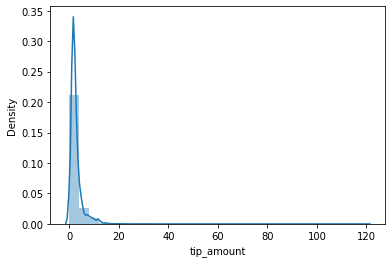

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(sample_df['tip_amount'], bins=30)

/home/binhducvu/jupyterenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


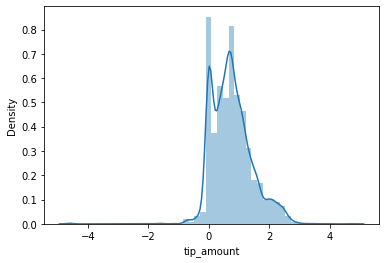

In [19]:
from numpy import log,sqrt
def logify(x):
    return log(x) if x else 0

sns.distplot(sample_df['tip_amount'].apply(logify), bins=50)
plt.show()

/home/binhducvu/jupyterenv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


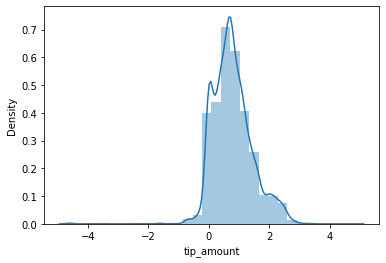

In [21]:
data = sample_df.loc[sample_df['tip_amount'] > 0, 'tip_amount']

sns.distplot(data.apply(logify), bins=30)
plt.show()

In [27]:
sample_df[['tip_amount','trip_distance']].corr(method='pearson')

,tip_amount,trip_distance
tip_amount,1.000000,0.696019
trip_distance,0.696019,1.000000


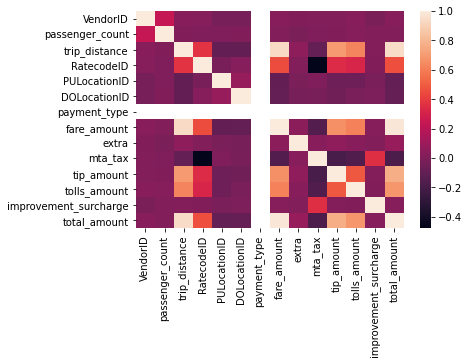

In [29]:
sns.heatmap(sample_df.corr())
plt.show()